In [ ]:
!pip install gym
!pip install gym[box2d]

In [3]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing

In [4]:
g = gym.make("Blackjack-v1", render_mode="rgb_array")

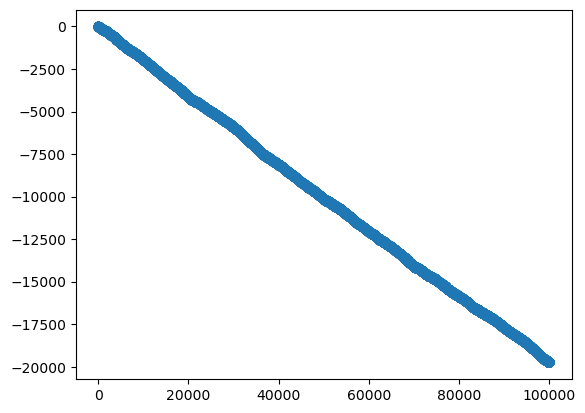

In [3]:
# Первая часть, с со стратегией 19, 20, 21. Уверенно проигрывает.

g.action_space.seed(42)

observation, info = g.reset(seed=42)
rewards = []
total_reward = 0
for game in range(100000):
    terminated = False
    truncated = False
    observation, info = g.reset()
        
    while not terminated or truncated:

        if observation[0] in [19, 20, 21]:
            observation, reward, terminated, truncated, info = g.step(0)
        else:
            observation, reward, terminated, truncated, info = g.step(1)
  
    
    total_reward += reward
    rewards.append(total_reward)
        

plt.scatter(range(len(rewards)),rewards )        

In [4]:
#Заполняю пространство состояний

def new_pi(init=False):
    card_values = [x for x in range(1,12)] # карты
    possible_scores = [x for x in range(1,23)]  # очки + перебор
    p = {}
    for cv in card_values:
        for ps in possible_scores:
            p[(ps,cv,False)] = np.random.random() if init else 0.0
            p[(ps,cv,True)] = np.random.random() if init else 0.0
    return(p)

In [ ]:
# Обучение без удвоения, на 100000 уходит в ~ -18000

g.action_space.seed()
n_games_in_step = 10000
n_steps = 1000
step = 1e-4

rewards = []

pi_trainable = new_pi(init=True) 

for training_step in range(n_steps):
    total_reward = 0
    pi_exp = new_pi(init=False)
    
    for game in range(n_games_in_step):
        terminated = False
        truncated = False
        observation, info = g.reset()
        pi_current = new_pi(init=False)
        used_keys = set()
        while not terminated or truncated:
            rnd_action=np.random.random()
            score = observation[0] if observation[0] < 22 else 22
            key = (score,observation[1], observation[2])
            used_keys.add(key)
            #print((score, observation[1]))
            if rnd_action < pi_trainable[key]:
                observation, reward, terminated, truncated, info = g.step(1)
                pi_current[(score,observation[1], observation[2])] += 1
                #print((score,observation[1]), pi_current[(score,observation[1])]) 
            else:
                observation, reward, terminated, truncated, info = g.step(0)
                pi_current[(score, observation[1], observation[2])] -= 1
            #if ((score,observation[1]) == (20, 10)):
                #print(game, 'ZZZZ', pi_current[(score,observation[1])], pi_exp[(score,observation[1])])
          
        total_reward += reward
        for s in used_keys:            
            pi_exp[s] += pi_current[s] * reward 
    print(training_step, total_reward, pi_trainable[(20, 10, 0)], pi_current[(20, 10, 0)], pi_exp[(20, 10,0)]  )
    rewards.append(total_reward)
    for s in pi_trainable:
            pi_trainable[s] = np.clip(pi_trainable[s] + pi_exp[s] * step, 0, 1)  
            #print(s,pi_current[s] * step / n_games_in_step)
     
    
plt.scatter(range(len(rewards)),rewards )    


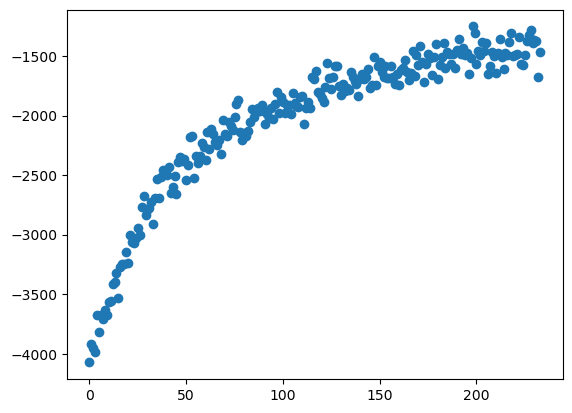

In [10]:
plt.scatter(range(len(rewards)),rewards )    

In [62]:
#Пространство состояний для стратегии с удвоением, вероятность выбора каждого действия вычисляется отдеьным масивом.
#Вероятность выбрать действие пропорциональна соотношению коэффициентов в массиве для каждого состояния.
def new_pi_double(init=False):
    card_values = [x for x in range(1,12)]
    possible_scores = [x for x in range(1,23)]  # + перебор
    p = {}
    for cv in card_values:
        for ps in possible_scores:
            p[(ps,cv,False)] = np.array([[1, 1, 1],[0.33,0.33,0.33]]) if init else np.array([0, 0, 0])
            p[(ps,cv,True)] = np.array([[1, 1, 1],[0.33,0.33,0.33]]) if init else np.array([0, 0, 0])
    return(p)

In [ ]:
# Для каждой игры заполняется массив аналогичный массиву состояний. Для действий приведших к успеху увеличивается коэффициент,
# для приведших к проигрышу уменьшается.


g.action_space.seed()
n_games_in_step = 100000
n_steps = 400
step = 1e-4

rewards = []

pi_trainable = new_pi_double(init=True)

pool = multiprocessing.Pool(8)

for training_step in range(n_steps):
    total_reward = 0
    pi_exp = new_pi_double(init=False)
    global_keys = set()
    for game in range(n_games_in_step):
        terminated = False
        truncated = False
        observation, info = g.reset()
        
        pi_current = new_pi_double(init=False)
        used_keys = set()
        actions = []
        states = []
        multiplyer = 1
        while not (terminated or truncated):
            rnd_action=np.random.random()
            score = observation[0] if observation[0] < 22 else 22
            action_array = pi_trainable[(score, observation[1], observation[2])][1]
            key = (score,observation[1], observation[2])
            used_keys.add(key)
            states.append(key)
            action_ranges = pi_trainable[key][1]
            # заполняем мссив с успешными / не успешными действиями
            if rnd_action < action_ranges[0]:
                #do hit
                observation, reward, terminated, truncated, info = g.step(1)
                pi_current[key][0] += 1
                actions.append('take')
                
            elif action_ranges[0] <= rnd_action < (action_ranges[0]+action_ranges[1]):
                #stop
                observation, reward, terminated, truncated, info = g.step(0)
                pi_current[key][1] += 1
                actions.append('check')
            else:
                #double
                pi_current[key][2] += 1
                observation, reward, terminated, truncated, info = g.step(1)
                key = (observation[0],observation[1], observation[2])
             
                states.append(key)
                if not (terminated or truncated):
                    observation, reward, terminated, truncated, info = g.step(0)
                multiplyer=2   
                actions.append('double')
     
            
        total_reward += reward * multiplyer
   
        global_keys.update(used_keys)
        #Находим действие, чаще всего приводившее к победе и обновляем его коэффициент
        mx_pv = -n_games_in_step
        for s in used_keys: 
            if np.max(pi_current[s] * reward * multiplyer) > mx_pv:
                mx_pv = np.max(pi_current[s] * reward * multiplyer)
                max_key = s
        
        global_keys.add(max_key)
        pi_exp[max_key] = pi_exp[max_key] + pi_current[max_key] * reward * multiplyer 
        
    print(len(global_keys),training_step, total_reward, pi_trainable[(12, 10, False)],  pi_exp[(12, 10, False)]  )       
    for s in global_keys:
        #print('zzz', pi_exp[s], pi_trainable[s])
        pi_trainable[s][0] = pi_trainable[s][0] + pi_exp[s]*step 
        new_sum = np.sum(pi_trainable[s][0])
        pi_trainable[s][0] = np.clip(pi_trainable[s][0], 0.00000000001, 1000) 
        while (new_sum < 0.3):
            pi_trainable[s][0] = pi_trainable[s][0] * 1000  
            new_sum = np.sum(pi_trainable[s][0])
            print('fix_small', s, pi_trainable[s])
        if new_sum > 1000:
            pi_trainable[s][0] = pi_trainable[s][0] / 1000 
            print('fix_big', s)
        pi_trainable[s][0] = np.clip(pi_trainable[s][0], 0.0000001, 1000)    
        pi_trainable[s][1] = pi_trainable[s][0] / np.sum(pi_trainable[s][0])
            #print(s, pi_trainable[s][0], pi_trainable[s][1])
            #print(s,pi_current[s] * step / n_games_in_step)
    rewards.append(total_reward)
    
plt.scatter(range(len(rewards)),rewards ) 

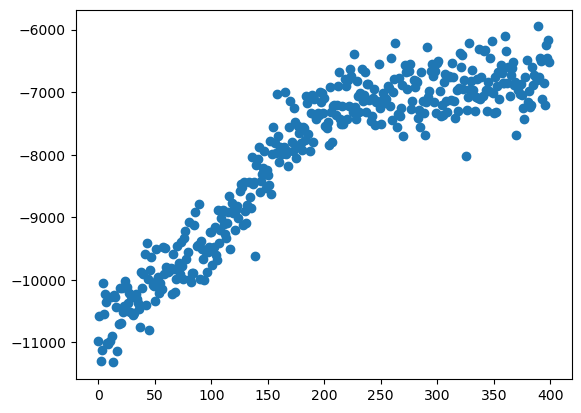

In [61]:
# эта модель доходит до -6500 на 100000 запусков
plt.scatter(range(len(rewards)),rewards ) 